In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import os
import re
from pyvis.network import Network
import community.community_louvain as community_louvain
from utils.functions import *

In [2]:
# Load spacy English language model
NER = spacy.load("en_core_web_sm")

In [3]:
## Load books 

In [5]:
# get all book files in the data/book directory
all_books = [b for b in os.scandir('data/books') if '.txt' in b.name]

In [6]:
# read the book and apply the Language model on the text
book = all_books[0]
book_text = open(book).read()
book_doc = NER(book_text)

In [7]:
#visualize identified entities
#displacy.render(book_doc[0:2000], style="ent", jupyter=True)

In [8]:
## Load character names

In [9]:
# Read character file 
character_df = pd.read_csv('./data/characters.csv')

In [10]:
# Remove unwanted texts and do cleaning of character names
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
character_df['character_firstname'] = character_df['character'].apply(lambda s: s 
                                                                      if s.startswith("The ") or 
                                                                      s.startswith("A ") or
                                                                      s.startswith("White ") or
                                                                      s.startswith("An ") 
                                                                      else s.split(' ', 1)[0])

In [11]:
pd.set_option('display.max_rows', None)

In [12]:
## Get named entity list per sentence

In [13]:
sentence_entity_df = []
# Loop through each sentence and store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sentence_entity_df.append({'sentence': sent, 'entities': entity_list})

sentence_entity_df = pd.DataFrame(sentence_entity_df)

In [14]:
# Function to filter out non-character entities eg. ["Geralt", "kkm", "2"] --> ['Geralt']
def filter_entity(entity_list, character_df):
    return [ent for ent in entity_list
            if ent in list(character_df.character)
            or ent in list(character_df.character_firstname)]

In [15]:
filter_entity(["Geralt", "kkm", "2"], character_df)

['Geralt']

In [16]:
sentence_entity_df['character_entities'] = sentence_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have have any character entities
sentence_entity_df_filtered = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]


In [17]:
# Take only the first name of character
sentence_entity_df_filtered['character_entities'] = sentence_entity_df_filtered['character_entities'].apply(lambda item: [s if s.startswith("The ") or s.startswith("A ") or s.startswith("An ") or s.startswith("White ") else s.split(' ', 1)[0] for s in item])

/tmp/ipykernel_5759/2249137871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_entity_df_filtered['character_entities'] = sentence_entity_df_filtered['character_entities'].apply(lambda item: [s if s.startswith("The ") or s.startswith("A ") or s.startswith("An ") or s.startswith("White ") else s.split(' ', 1)[0] for s in item])


In [18]:
pd.reset_option('^display.', silent=True)
# sentence_entity_df_filtered

In [19]:
# Create relationship between characters

In [20]:
window_size = 5
relationships = []
for i in range (sentence_entity_df_filtered.index[-1]):
    end_i = min(i + window_size, sentence_entity_df_filtered.index[-1])
    char_list = sum(sentence_entity_df_filtered.loc[i: end_i].character_entities, [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for index, a in enumerate(char_unique[:-1]):
            b = char_unique[index + 1]
            relationships.append({"source": a, "target": b})
    

In [ ]:
relationship_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)
relationship_df

In [22]:
# Remove duplicate relationships

In [23]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
# relationship_df

In [24]:
# Define a weight to each relationship based on number of occurrence
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum()

In [ ]:
relationship_df.head(10)

In [27]:
# Graph analysis and visualization

In [28]:
GRAPH = nx.from_pandas_edgelist(relationship_df, 
                                source = "source",
                                target = "target",
                                edge_attr  = "value",
                                create_using = nx.Graph())

In [29]:
#### Graph visualization - NetworkX

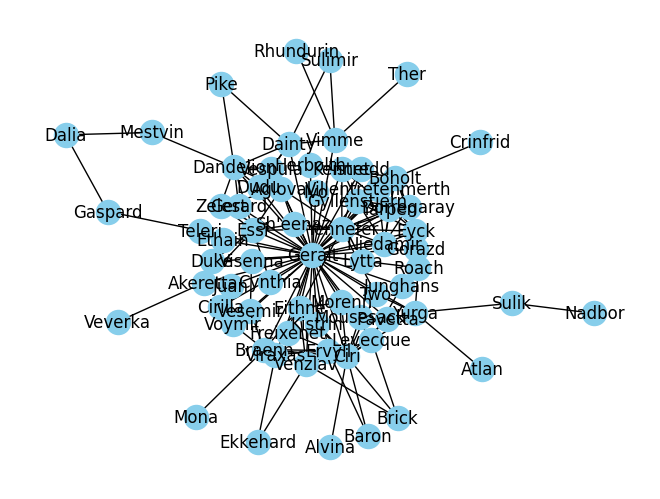

In [30]:
pos = nx.kamada_kawai_layout(GRAPH)
nx.draw(GRAPH, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [31]:
#### Graph visualization - Pyvis

In [ ]:
net = Network(notebook=True, cdn_resources='in_line', width="1000px", height="700px", bgcolor="#222222", font_color="white")

node_degree = dict(GRAPH.degree)

#setting up the node size attribute based on degree of the node
nx.set_node_attributes(GRAPH, node_degree, "size")

net.from_nx(GRAPH)
net.show("./graph/witcher_network.html")

In [33]:
### The Most important characters in The Witcher 

<Axes: >

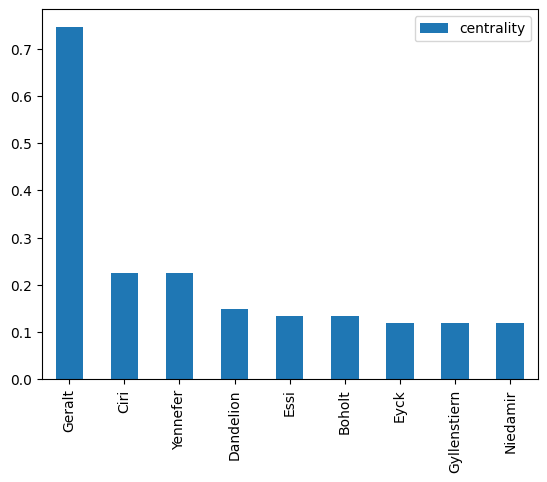

In [34]:
# Degree Centrality
degree_dict = nx.degree_centrality(GRAPH)

degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

# Plot Top-10 nodes

degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

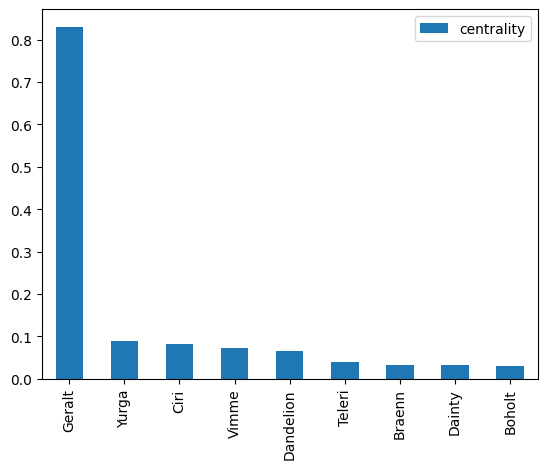

In [35]:
# Between-ness centrality

betweenness_dict = nx.betweenness_centrality(GRAPH)

betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])

# Plot Top-10 nodes

betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

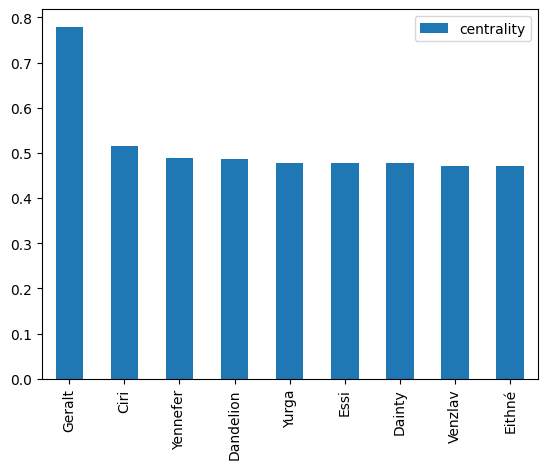

In [36]:
# closeness centrality

closeness_dict = nx.closeness_centrality(GRAPH)

closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])

# Plot Top-10 nodes

closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [37]:
# Save centrality measures in the node attribute

nx.set_node_attributes(GRAPH, degree_dict, "degree_centrality")

nx.set_node_attributes(GRAPH, betweenness_dict, "betweenness_centrality")

nx.set_node_attributes(GRAPH, closeness_dict, "closeness_centrality")


In [38]:
# Community detection

In [39]:

communities = community_louvain.best_partition(GRAPH)

nx.set_node_attributes(GRAPH, communities, "group")

In [ ]:
community_net = Network(notebook=True, cdn_resources='in_line', width="1000px", height="700px", bgcolor="#222222", font_color="white")

community_net.from_nx(GRAPH)
community_net.show("./graph/witcher_communities.html")


In [42]:
# Evolution of Characters importance

In [53]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('./data/books') if '.txt' in b.name]

#Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [54]:
# Loop through book list and create graphs
all_books_relationship = []
for book in all_books:
    book_text = ner(book)
    
    character_df = pd.read_csv('./data/characters.csv')
    # Remove unwanted texts and do cleaning of character names
    character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
    character_df['character_firstname'] = character_df['character'].apply(lambda s: s 
                                                                        if s.startswith("The ") or 
                                                                        s.startswith("A ") or
                                                                        s.startswith("White ") or
                                                                        s.startswith("An ") 
                                                                        else s.split(' ', 1)[0])
    
    # Get list of entities per sentences
    sentence_entity_df = get_ne_list_per_sentence(book_text)
    
    # select only character entities
    sentence_entity_df['character_entities'] = sentence_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

    # Filter out sentences that don't have have any character entities
    sentence_entity_df_filtered = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]
    
    # Take only the first name of character
    sentence_entity_df_filtered['character_entities'] = sentence_entity_df_filtered['character_entities'].apply(lambda item: [s if s.startswith("The ") or s.startswith("A ") or s.startswith("An ") or s.startswith("White ") else s.split(' ', 1)[0] for s in item])
    
    
    #Create relationship dataframe
    relationship_df = create_relationships(df = sentence_entity_df_filtered, window_size = 5)
    all_books_relationship.append(relationship_df)
    weighted_relationship_df = weighted_relationship(relationship_df)
    # Create a graph from a pandas dataframe
    GRAPH = nx.from_pandas_edgelist(weighted_relationship_df, 
                                source = "source",
                                target = "target",
                                edge_attr  = "value",
                                create_using = nx.Graph())
    
    books_graph.append(GRAPH)
    

/tmp/ipykernel_5759/3345701703.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_entity_df_filtered['character_entities'] = sentence_entity_df_filtered['character_entities'].apply(lambda item: [s if s.startswith("The ") or s.startswith("A ") or s.startswith("An ") or s.startswith("White ") else s.split(' ', 1)[0] for s in item])
/tmp/ipykernel_5759/3345701703.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_entity_df_filtered['character_entities'] = sentence_entity_df_filtered['char

<Axes: >

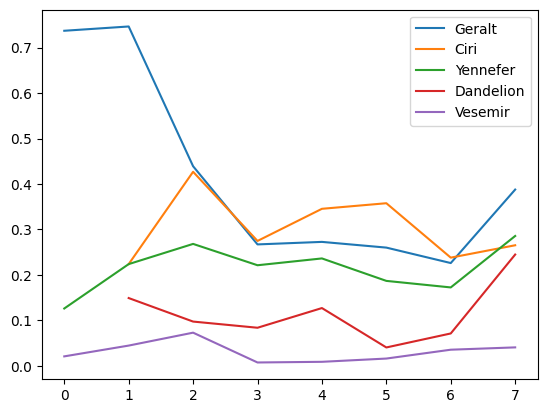

In [55]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DatFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()


In [56]:
books_graph